## Singular Value Decomposition (SVD)

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [6]:
data = load_dataset("nbtpj/movielens-1m-ratings")["train"].shuffle(seed=10).select(range(200000))
movielens_df = pd.DataFrame(data)
movielens_df = movielens_df[["user_id", "movie_id", "user_rating"]]

user_ids = movielens_df["user_id"].unique()
user_id_map = {id: index for index, id in enumerate(user_ids)}
movie_ids = movielens_df["movie_id"].unique()
movie_id_map = {id: index for index, id in enumerate(movie_ids)}

movielens_df["user_id"] = movielens_df["user_id"].map(user_id_map)
movielens_df["movie_id"] = movielens_df["movie_id"].map(movie_id_map)

Found cached dataset parquet (/Users/jaypark/.cache/huggingface/datasets/nbtpj___parquet/nbtpj--movielens-1m-ratings-b1aa424c884e38a3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /Users/jaypark/.cache/huggingface/datasets/nbtpj___parquet/nbtpj--movielens-1m-ratings-b1aa424c884e38a3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-15aa091e090a52af.arrow


In [7]:
train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=10)

user_avg_ratings = train_data.groupby("user_id")["user_rating"].mean().to_dict()
ratings_matrix = train_data.pivot(index="user_id", columns="movie_id", values="user_rating").apply(lambda x: x.fillna(user_avg_ratings[x.name]),axis = 1)
user_rating_mean = ratings_matrix.mean(axis=1)
ratings_matrix_demeaned = ratings_matrix - user_rating_mean.values.reshape(-1, 1)
ratings_matrix_csr = csr_matrix(ratings_matrix_demeaned.values)

U, sigma, Vt = svds(ratings_matrix_csr, k=50)
sigma = np.diag(sigma)

In [9]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_rating_mean.values.reshape(-1, 1)
user_mean = np.mean(all_user_predicted_ratings)

def predict_rating_svd(user_id:int, movie_id: int):
    if user_id < all_user_predicted_ratings.shape[0] and movie_id < all_user_predicted_ratings.shape[1]:
        return all_user_predicted_ratings[user_id, movie_id]
    else:
        return user_mean
    
predictions : list[float] = []
true_ratings : list[float] = []

for _, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    user_id = int(row["user_id"])
    movie_id = int(row["movie_id"])
    user_rating = row["user_rating"]
    
    predicted_rating = predict_rating_svd(user_id, movie_id)
    predictions.append(round(predicted_rating))
    true_ratings.append(user_rating)
    
rmse = np.sqrt(np.mean((np.array(predictions) - np.array(true_ratings))**2))
print(f"RMSE: {rmse:.2f}")



100%|██████████| 40000/40000 [00:00<00:00, 71152.22it/s]

RMSE: 1.21


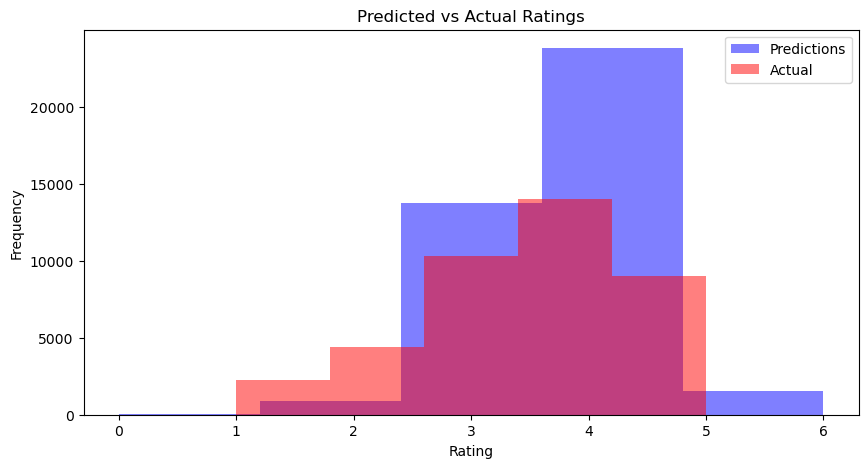

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=5, alpha=0.5, label="Predictions", color="blue")
plt.hist(true_ratings, bins=5, alpha=0.5, label="Actual", color="red")
plt.title("Predicted vs Actual Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()